In [1]:
import numpy as np
import BigFunctions as BF
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import uproot as ur
import warnings
import gc
warnings.filterwarnings('ignore')

# Parameters to vary
- corr_t: time correlation window
- b: point at origin for Energy 2 as function of Energy 1
- dt_max: maximum $\Delta t$
- N_bins: number of bins used for the fit

# Raw Data
## Single data set

In [2]:
"""
#Reading the variables

input_path = "../data/bigdata_CFD_23092024_0001.root"
with ur.open(input_path) as file:
    outTree = file["DataTree"]
    label = outTree["label"].array(library = "np")
    time = outTree["time"].array(library = "np")*10**-6   #[µs]
    nrj = outTree["nrj"].array(library = "np")
    pileup = outTree["pileup"].array(library = "np")

print("Duration of the data acquisition:  ", max(time)*10**(-6)/3600, "hours")
print("Number of events acquired:         ", len(label)/10**6, "million")
print("Total number of pileups:           ", len(pileup[pileup == True]))
print("Number of events acquired with PM2:", len(label[label == 2])/10**6, "million")
"""

'\n#Reading the variables\n\ninput_path = "../data/bigdata_CFD_23092024_0001.root"\nwith ur.open(input_path) as file:\n    outTree = file["DataTree"]\n    label = outTree["label"].array(library = "np")\n    time = outTree["time"].array(library = "np")*10**-6   #[µs]\n    nrj = outTree["nrj"].array(library = "np")\n    pileup = outTree["pileup"].array(library = "np")\n\nprint("Duration of the data acquisition:  ", max(time)*10**(-6)/3600, "hours")\nprint("Number of events acquired:         ", len(label)/10**6, "million")\nprint("Total number of pileups:           ", len(pileup[pileup == True]))\nprint("Number of events acquired with PM2:", len(label[label == 2])/10**6, "million")\n'

## Concatenation

In [2]:
#Reading the variables

def vars_data(data):
    with ur.open(data) as file:
        outTree = file["DataTree"]
        label = outTree["label"].array(library = "np")
        time = outTree["time"].array(library = "np")*10**-6   #[µs]
        nrj = outTree["nrj"].array(library = "np")
        pileup = outTree["pileup"].array(library = "np")

    print("Duration of the data acquisition:", max(time)*10**(-6)/3600, "hours")
    print("Number of events acquired:", len(label)/10**6, "million")
    print("Number of events acquired with PM2:", len(label[label == 2])/10**6, "million")
    
    return label, time, nrj, pileup

vars_23_09 = vars_data("../data/bigdata_CFD_23092024_0001.root")
vars_26_09 = vars_data("../data/bigdata_CFD_26092024_0001.root")

label = np.concatenate((vars_23_09[0], vars_26_09[0]), axis=None)
time = np.concatenate((vars_23_09[1], 100+vars_23_09[1][-1]+vars_26_09[1]), axis=None) 
nrj = np.concatenate((vars_23_09[2], vars_26_09[2]), axis=None)
pileup = np.concatenate((vars_23_09[3], vars_26_09[3]), axis=None)

Duration of the data acquisition: 29.660985277428928 hours
Number of events acquired: 38.426892 million
Number of events acquired with PM2: 21.276869 million
Duration of the data acquisition: 25.804306768414815 hours
Number of events acquired: 25.593394 million
Number of events acquired with PM2: 12.796697 million


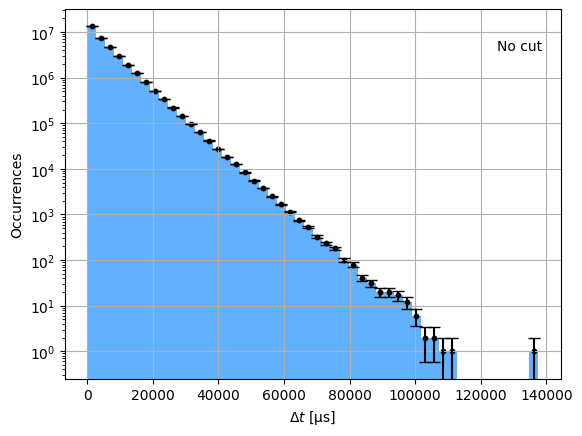

In [3]:
#Raw dt (with PM2)

dt2_raw = time[label == 2][1:] - time[label == 2][:-1]

hist = np.histogram(dt2_raw[dt2_raw < 150000], bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt2_raw[dt2_raw < 150000], bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(125000, 4e6, 'No cut')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
#plt.title('Raw $\Delta t$ Acquired With PMT$_2$')
plt.yscale('log')
plt.grid()
plt.savefig('Raw delta t')
plt.show()

del dt2_raw

# Correlation

In [4]:
#Time Correlation

corr_t = 5*10**-3   #Correlation window (5 ns here)
corr_mask = (time[1:]-time[:-1]<corr_t) & (label[1:] != label[:-1])

correl_both = (np.insert(corr_mask,0,False))|(np.append(corr_mask,False))
del(corr_mask)

t = time[correl_both]
l = label[correl_both]
p = pileup[correl_both]
e = nrj[correl_both]

t1 = time[correl_both & (label==1)]
t2 = time[correl_both & (label==2)]
nrj1 = nrj[correl_both & (label==1)]
nrj2 = nrj[correl_both & (label==2)]

dt2 = t2[1:]-t2[:-1]
dt1 = t1[1:]-t1[:-1]

print("Number of events after correlation:                       ", len(t)/10**6, "million")
print("Dead time:                                                ", min(dt2), "µs")
print("Total number of pileups after correlation:                ", len(p[p == True]))
print("Number of events acquired with PM2 after time correlation:", len(l[l == 2])/10**6, "million (", len(l[l == 2])*100/len(label[label == 2]), "% )")

del t
del p
del e
del pileup

Number of events after correlation:                        46.74009 million
Dead time:                                                 0.1583709716796875 µs
Total number of pileups after correlation:                 0
Number of events acquired with PM2 after time correlation: 23.370045 million ( 68.58702432260833 % )


... After time correlation only ...


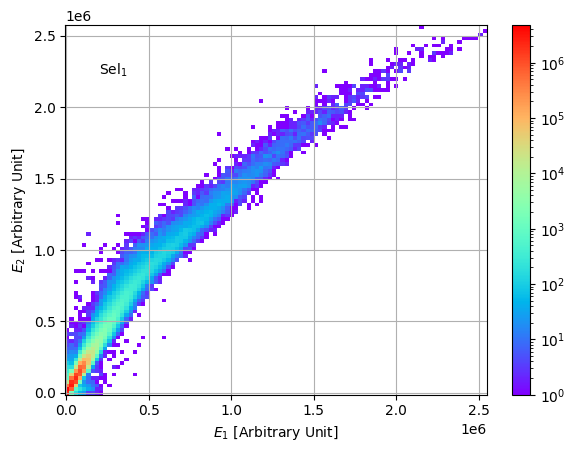

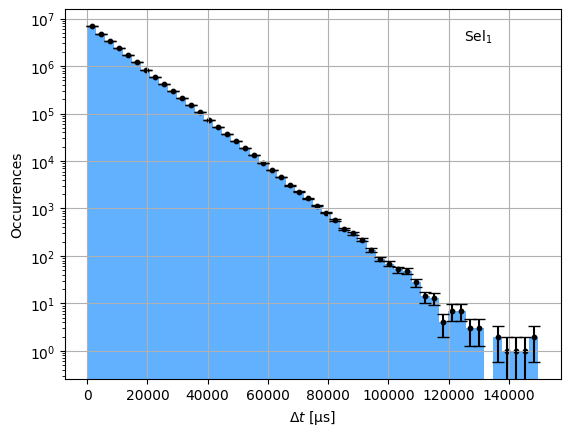

In [5]:
#Energy Correlation

#After time correlation only
print('... After time correlation only ...')

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1, nrj2, bins =(100,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$E_1$ [Arbitrary Unit]')
ax1.set_ylabel('$E_2$ [Arbitrary Unit]')
#ax1.set_title('$E_2$ as Function of $E_1$')
ax1.grid()
ax1.text(0.2e6, 2.23e6, 'Sel$_1$')
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.savefig('E2(E1)_Sel1')
plt.show()

hist = np.histogram(dt2[dt2 < 150000], bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt2[dt2 < 150000], bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(125000, 3.5e6, 'Sel$_1$')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
#plt.title('$\Delta t$ Acquired With PMT$_2$ After Time Correlation')
plt.grid()
plt.yscale('log')
plt.savefig('delta t_Sel1')
plt.show()

... After correlation and cut on nrj_max ...
a = 2.0000777712010436 +/- 5.863832345345051e-06


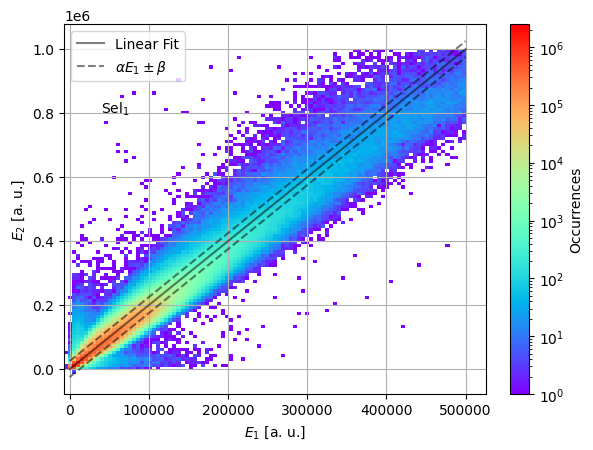

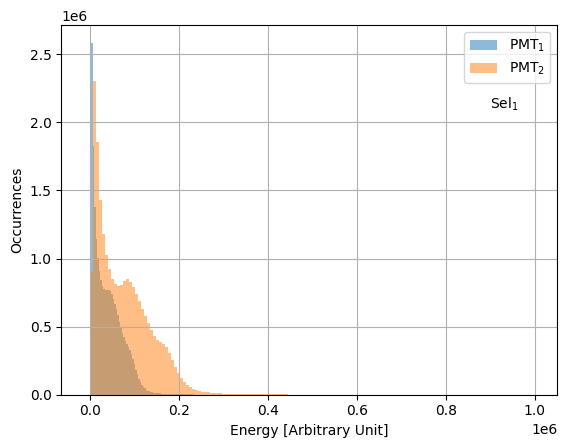

In [6]:
#After correlation and cut on nrj_max
print('... After correlation and cut on nrj_max ...')

nrj1_max = 0.5e6
nrj2_max = 1e6

#First mask: cut on maximum energies
mask1 = (nrj1 < nrj1_max)&(nrj2 < nrj2_max)

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[mask1], 
                                 nrj2[mask1], 
                                 bins =(100,100))

popt, cov = curve_fit(BF.lin, xe_1, ye_1)
a = popt[0]
a_err = np.sqrt(cov[0,0])
print("a =", a, "+/-", a_err)

pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$E_1$ [a. u.]')
ax1.set_ylabel('$E_2$ [a. u.]')
#ax1.set_title('$E_2$ as Function of $E_1$')
ax1.grid()
ax1.plot(np.array([0, 5e5]), a*np.array([0, 5e5]), c='k', alpha = 0.5, label = 'Linear Fit')
ax1.plot(np.array([0, 5e5]), a*np.array([0, 5e5])+25000, '--', c='k', alpha = 0.5, label = r'$\alpha E_1\pm\beta$')
ax1.plot(np.array([0, 5e5]), a*np.array([0, 5e5])-25000, '--', c='k', alpha = 0.5)
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1, label = 'Occurrences')
plt.text(40000, 0.8e6, 'Sel$_1$')
plt.legend()
plt.savefig('E2(E1)_Sel1_zoom')
plt.show()

plt.figure()
plt.hist(nrj1[mask1], bins = 150, alpha = 0.5, label = "PMT$_1$")
plt.hist(nrj2[mask1], bins = 150, alpha = 0.5, label = "PMT$_2$")
plt.xlabel("Energy [Arbitrary Unit]")
plt.ylabel("Occurrences")
plt.grid()
plt.legend()
plt.text(0.9e6, 2.1e6, 'Sel$_1$')
plt.show()

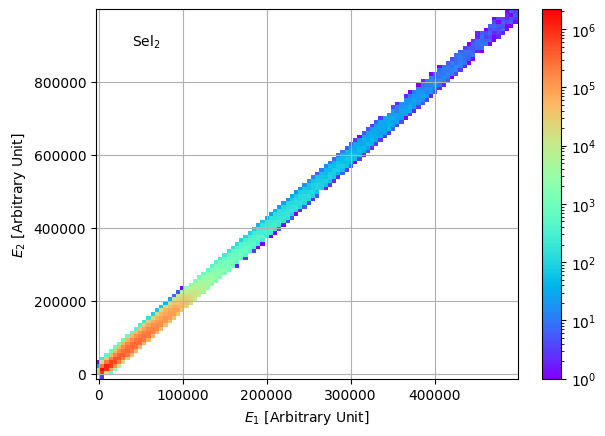

In [7]:
#Linearity

b = 0.025e6

#Second mask: to keep energies around the linear line only
mask2 = (a*nrj1+b>=nrj2) & (a*nrj1-b <= nrj2)

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1[mask1 & mask2], 
                                 nrj2[mask1 & mask2], 
                                 bins =(100,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$E_1$ [Arbitrary Unit]')
ax1.set_ylabel('$E_2$ [Arbitrary Unit]')
#ax1.set_title('$E_2$ as Function of $E_1$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.text(40000, 0.9e6, 'Sel$_2$')
plt.savefig('E2(E1)_Sel2')
plt.show()

Number of events acquired with PM2 after time and energy correlation: 20.444609 million ( 60.00137760749785 % )


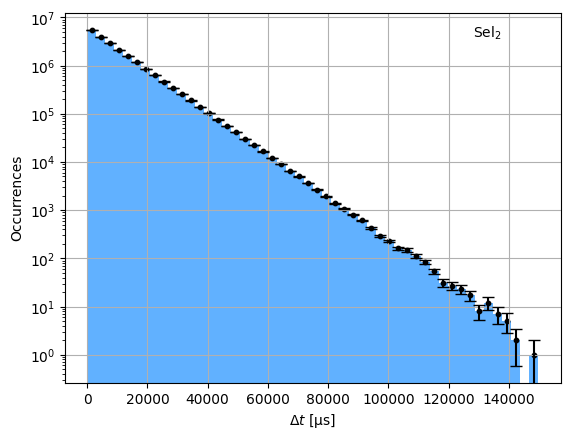

In [8]:
#PM2 variables after correlation cuts (time and energy)
nrj22 = nrj2[mask1 & mask2]
t22 = t2[mask1 & mask2]
dt22 = t22[1:]-t22[:-1]

print("Number of events acquired with PM2 after time and energy correlation:", len(t22)/10**6, "million (", len(t22)*100/len(label[label == 2]), "% )")

hist = np.histogram(dt22[dt22 < 150000], bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

plt.figure()
plt.hist(dt22[dt22 < 150000], bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(128000, 3.8e6, 'Sel$_2$')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
#plt.title('$\Delta t$ Acquired With PMT$_2$ After Time  and Energy Correlation')
plt.grid()
plt.yscale('log')
plt.savefig('delta t_Sel2')
plt.show()

# Additional Cuts

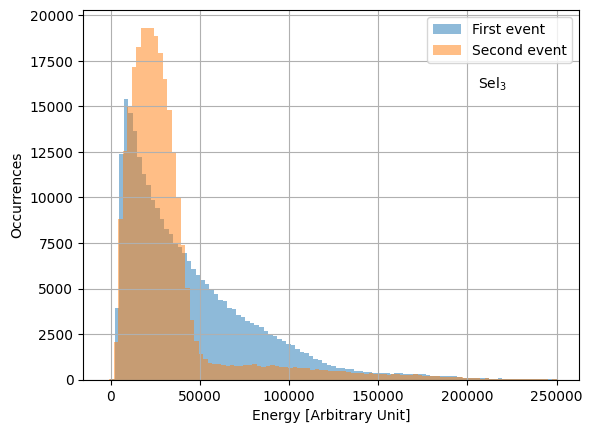

Number of events acquired with PM2 after time and energy correlation, and cut on dt_max:
 0.272407 million ( 0.7994672468387958 % )


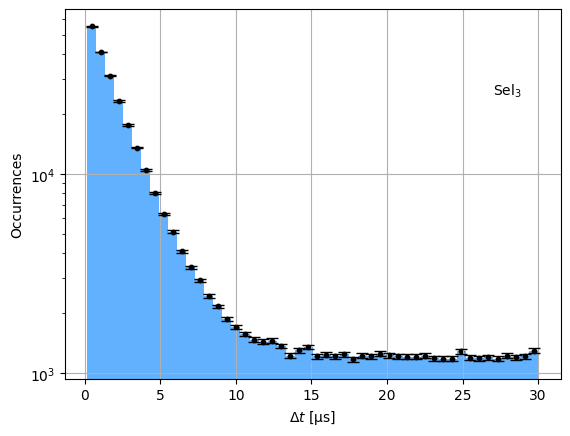

Number of events acquired with PM2 after time and energy correlation, cut on dt_max and on maximum second event energy:
 0.24046 million ( 0.7057083488120968 % )


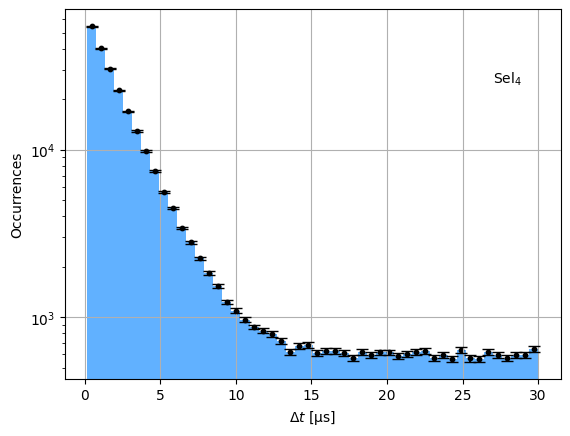

: 

In [17]:
#Cut on maximum dt
dt_max = 30
dt = dt22[(dt22 < dt_max)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<0.25e6)]
nrjµ = nrj22[:-1][(dt22 < dt_max)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<0.25e6)]
nrje = nrj22[1:][(dt22 < dt_max)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<0.25e6)]

plt.figure()
plt.hist(nrjµ, bins = 100, label = 'First event', alpha = 0.5)
plt.hist(nrje, bins = 100, label = 'Second event', alpha = 0.5)
plt.xlabel('Energy [a. u.]')
plt.ylabel('Occurrences')
plt.grid()
plt.legend()
plt.text(206000, 16000, 'Sel$_3$')
plt.savefig('EeEµ_Sel3')
plt.show()

print("Number of events acquired with PM2 after time and energy correlation, and cut on dt_max:\n", 
      len(dt)/10**6, "million (", len(dt)*100/len(label[label == 2]), "% )")

hist = np.histogram(dt, bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt, bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(27, 25000, 'Sel$_3$')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
#plt.title('$\Delta t$ Acquired With PMT$_2$ After Time and Energy Correlation\nAnd Cut on $\Delta t_{max}$')
plt.yscale('log')
plt.grid()
plt.savefig('delta t_Sel3')
plt.show()


#Final cut: energy of the second event (we remove the weird tail)
dt_final = dt22[(dt22 < dt_max)&(nrj22[:-1]<0.25e6)&(nrj22[1:]<50000)]

print("Number of events acquired with PM2 after time and energy correlation, cut on dt_max and on maximum second event energy:\n", 
      len(dt_final)/10**6, "million (", len(dt_final)*100/len(label[label == 2]), "% )")

hist = np.histogram(dt_final, bins = 50)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)
plt.figure()
plt.hist(dt_final, bins = 50, color='dodgerblue', alpha = 0.7)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='-', capsize=4, c='k')
plt.scatter(x, y, c='k', s=10)
plt.text(27, 25000, 'Sel$_4$')
plt.xlabel('$\Delta t$ [µs]')
plt.ylabel('Occurrences')
plt.yscale('log')
plt.grid()
plt.savefig('delta t_Sel4')
plt.show()

# Fit

... Fit with two exponentials ...
chi2 =  1.0422560603462914 +/- 0.10101525445522107
tau =  2.254927566349109 +/- 0.04002093713276153 [µs]
lambda_c =  0.101145742954542 +/- 0.019591555230443754 [µs]


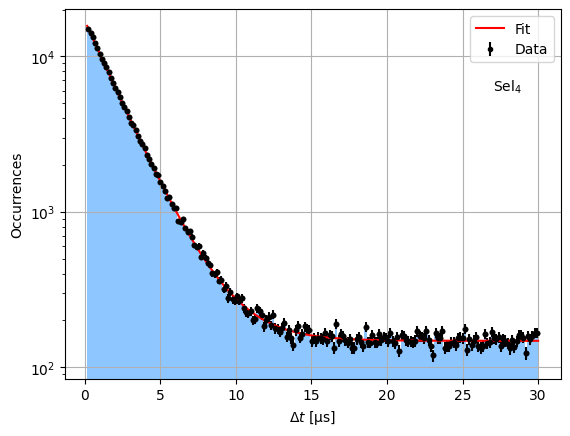

In [11]:
N_bins = 200
hist = np.histogram(dt_final, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

popt, cov = curve_fit(BF.exp4, x, y, sigma = y_err, absolute_sigma = True, p0 = np.array([4e6, 2.2, 0.1, 200]))
N0 = popt[0]
tau= popt[1]
tau_err = np.sqrt(cov[1,1])
lambda_c = popt[2]
lambda_c_err = np.sqrt(cov[2,2])
C = popt[3]

chi2 = BF.chi2_norm(y, BF.exp4(x, N0, tau, lambda_c, C), y_err, 4)[0]
chi2_err = BF.chi2_norm(y, BF.exp4(x, N0, tau, lambda_c, C), y_err, 4)[1]
print("... Fit with two exponentials ...")
print("chi2 = ", chi2, '+/-', chi2_err)

print('tau = ', tau, '+/-', tau_err, '[µs]')
print('lambda_c = ', lambda_c, '+/-', lambda_c_err, '[µs]')

plt.figure()
plt.hist(dt_final, bins = N_bins, color='dodgerblue', alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', marker='o', markersize = 3, c='k', label = 'Data')
plt.scatter(x, y, c='k', s=10)
plt.plot(np.linspace(min(dt_final), max(dt_final), 100), 
         BF.exp4(np.linspace(min(dt_final), max(dt_final), 100), N0, tau, lambda_c, C), 
         label = 'Fit',
         c='r')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.yscale('log')
plt.legend()
plt.text(27, 6000, 'Sel$_4$')
plt.grid()
plt.savefig('delta t_fit')
plt.show()

In [4]:
import numpy as np
print(max(abs(2.2549-2.2543), abs(2.2549-2.2555)))
print(np.sqrt(0.011335**2+0.009976**2+0.015945**2+0.002820**2))
print(np.sqrt(0.011335**2+0.009976**2+0.015945**2+0.002820**2+0.0006**2))
print('\n')
print(max(abs(0.101146-0.101175), abs(0.101146-0.101174)))
print(np.sqrt(0.004374**2+0.005119**2+0.007079**2+0.001542**2))
print(np.sqrt(0.004374**2+0.005119**2+0.007079**2+0.001542**2+(2.9e-5)**2))

0.0005999999999999339
0.022140420637377242
0.02214854907211757


2.9000000000001247e-05
0.009890704828271847
0.009890747342845231
